# Import needed libraries
To make things work ensure that you have this libraries installed.

In [1]:
%pip install split-folders imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=dd310313a0761e62984e6745a6ebe298cdb991279a93754388eb3fe5d0ceca61
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-5azqul53
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-5azqul53
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 799.8 kB/s eta 0:00:00a 0:00:01
  Created wheel for image_classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20031 sha256=e4fab216cf08e97b341b44552cb142553a207ee4c63024bceeef1b21e2fa0a1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-qfhoogsj/wheels/f5/13/cb/b1dbd79043c5a389742e422859b0b663adcd7b5c220928c339
Successfully built image_classifiers
Note: you may need to restart the kernel to use updated packages.


In [29]:
import os
import numpy as np
import splitfolders
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from string import digits
from imutils import paths
from random import choices
from typing import Tuple, List
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import GRU, Dense, Bidirectional, InputLayer, Reshape

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalMaxPooling2D, Dense, Dropout, Input
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.layers import Dropout, Concatenate, Flatten
from tensorflow.keras import Model

import keras
from classification_models.keras import Classifiers

# Data
The **Dataset** class is designed as a helper tool for loading and preparing image datasets for training machine learning models.

In [4]:
class Dataset:

    MAX_IMAGES_PER_GENRE = 5_000
    
    def __init__(self, path: str, output: str | None = None, ratio: Tuple[float, float, float] = (.70, .15, .15), split: bool = True, split_folders: bool = False, image_size: Tuple[int, int] = (224,224), batch_size: int = 8 , cache: bool = True):
        assert sum(ratio) == 1.0

        self.path = path
        self.labels = [name for name in tqdm(os.listdir(self.path)) if os.path.isdir(os.path.join(self.path, name))]
        
        self.cache = cache
        self.ratio = ratio
        
        self.output_path = output if output else f"./data-{''.join(choices(digits, k=5))}"
        
        self.train = os.path.sep.join([self.output_path, 'train'])
        self.val = os.path.sep.join([self.output_path, 'val'])
        self.test = os.path.sep.join([self.output_path, 'test'])
        
        self.image_size = image_size
        self.batch_size = batch_size
        
        assert split == True or split_folders == True or output is not None
        
        if split:
            self.__split()
        elif split_folders:
            self.__split_folder()
            
        self.__generate()
    
    def __split(self):
        tmp_ratio = (1.0 - self.ratio[0])
        val_test_ratio = self.ratio[1] / tmp_ratio
        
        def get_genres(path):
            genres = {}
            for image_path in tqdm(list(paths.list_images(path))):
                genre = os.path.basename(os.path.dirname(image_path))

                if genre not in genres:
                    genres[genre] = []
                
                if len(genres[genre]) >= Dataset.MAX_IMAGES_PER_GENRE:
                    continue
                
                genres[genre].append(image_path)
            
            return genres

        
        def split_genre(genre):
            train, tmp = train_test_split(genre, test_size=tmp_ratio, random_state=42)
            test, val = train_test_split(tmp, test_size=val_test_ratio, random_state=42)
            
            return train, val, test
        
        self.train, self.val, self.test = [], [], []
        genres = get_genres(self.path)
        for genre in genres.values():
            train, val, test = split_genre(genre)
            self.train.extend(train)
            self.val.extend(val)
            self.test.extend(test)
    
        np.random.shuffle(self.train)
        np.random.shuffle(self.val)
        np.random.shuffle(self.test)
    
    def __split_folder(self):
        splitfolders.ratio(self.path, output=self.output_path, seed=42, ratio=self.ratio, group_prefix=None)
    
    def __generate(self):
        def load_images(image_path):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            image = tf.image.resize(image, self.image_size)
            
            label = tf.strings.split(image_path, os.path.sep)[-2]
            label = tf.cast(tf.equal(self.labels, label), tf.int32)
    
            return (image, label)
        
        def get_paths(x):
            if isinstance(x, str):
                return paths.list_images(x)
            else:
                return x
        
        train_paths = get_paths(self.train)
        self.train_len = len(train_paths) // self.batch_size
        self.train = tf.data.Dataset.from_tensor_slices(train_paths)
        self.train = (self.train
            .shuffle(len(train_paths), reshuffle_each_iteration=True)
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.train = self.train.cache()
        
        val_paths = get_paths(self.val)
        self.val_len = len(val_paths) // self.batch_size
        self.val = tf.data.Dataset.from_tensor_slices(val_paths)
        self.val = (self.val
            .shuffle(len(val_paths))
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.val = val.train.cache()
        
        test_paths = get_paths(self.test)
        self.test_len = len(test_paths) // self.batch_size
        self.test = tf.data.Dataset.from_tensor_slices(test_paths)
        self.test = (self.test
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.test = self.test.cache()

# Helper functions
The following functions are helpful tools for visualising model training progress and evaluating model performance through confusion matrix analysis.\

In [5]:
def plot_history(history, metric: str = '', ylim: List[float] | None = None):
    h = history.history
    plt.figure(figsize=(15,5))
    plt.plot(h[metric])
    plt.plot(h[f'val_{metric}'])
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend([metric, f'val_{metric}'], loc='upper left')
    if ylim:
        axes = plt.gca()
        axes.set_ylim(ylim)
    plt.show()
    
def show_confusion_matrix(y_true, y_pred, labels: List[str] = []):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(labels), len(labels)))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Bi-GRU 
The **build_model** function is a utility designed to construct and compile a model. The **STFT** and **Mel Spectrogram** are used to learn this model.

In [26]:
def build_BIGRU_model(height=224, width=224, channels=3):
    input_shape = (height, width, channels)
    
    inputs = Input(shape=input_shape)
    reshaped = Reshape((width, height * channels))(inputs)
    bi_gru = Bidirectional(GRU(256, return_sequences=True))(reshaped)
    bi_gru = tf.keras.layers.Flatten()(bi_gru)
    dense = Dense(512, activation='elu')(bi_gru)
    
    model = Model(inputs=inputs, outputs=dense)
    
    return model

# Resnet18

In [45]:
def build_RESNET_model(input_shape=(224, 224, 3)):
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    
    base_model = ResNet18(input_shape=input_shape, weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x) 
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

In [31]:
def build_combined_model(height=224, width=224, channels=3, genres=10):
    input_shape = (height, width, channels)
    
    resnet_model = build_RESNET_model(input_shape=input_shape)
    bigru_model = build_BIGRU_model(height=height, width=width, channels=channels)
    
    combined_input = Input(shape=input_shape)
    resnet_output = resnet_model(combined_input)
    bigru_output = bigru_model(combined_input)
    
    combined_output = Concatenate()([resnet_output, bigru_output])
    final_output = Dropout(0.5)(combined_output)
    final_output = Dense(512, activation='relu')(final_output)
    final_output = Dense(genres, activation='softmax')(final_output)
    
    model = Model(inputs=combined_input, outputs=final_output)
    
    return model

# STFT

In [43]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/stft', batch_size=batch_size, cache=False)

100%|██████████| 4995/4995 [00:00<00:00, 223527.36it/s]


In [46]:
model = build_combined_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_61"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_57       │ (None, 512)       │ 11,451,593 │ input_layer_13[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_59       │ (None, 512)       │ 60,149,248 │ input_layer_13[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 1024)      │          0 │ functional_57[0]… │
│ (Concatenate)       │                   │            │ functional_59[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 1024)      │          0 │ concatenate_6[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 512)       │    524,800 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 10)        │      5,130 │ dense_25[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 72,130,771 (275.16 MB)

 Trainable params: 72,121,805 (275.12 MB)

 Non-trainable params: 8,966 (35.02 KB)

In [47]:
epochs = 30

history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 269ms/step - accuracy: 0.1929 - loss: 3.1701 - val_accuracy: 0.3967 - val_loss: 1.7329
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 248ms/step - accuracy: 0.5061 - loss: 1.4534 - val_accuracy: 0.4924 - val_loss: 1.4296
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 246ms/step - accuracy: 0.6254 - loss: 1.0484 - val_accuracy: 0.4924 - val_loss: 1.4404
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step - accuracy: 0.7115 - loss: 0.8418 - val_accuracy: 0.4058 - val_loss: 1.6721
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 248ms/step - accuracy: 0.8034 - loss: 0.5791 - val_accuracy: 0.3783 - val_loss: 1.8557
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step - accuracy: 0.8500 - loss: 0.4330 - val_accuracy: 0.4801 - val_loss: 1.6398
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 249ms/step - accuracy: 0.8923 - loss: 0.3057 - val_accuracy: 0.4278 - val_loss: 2.0330
Epoch 8/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step - accuracy: 0.9451 - loss: 0

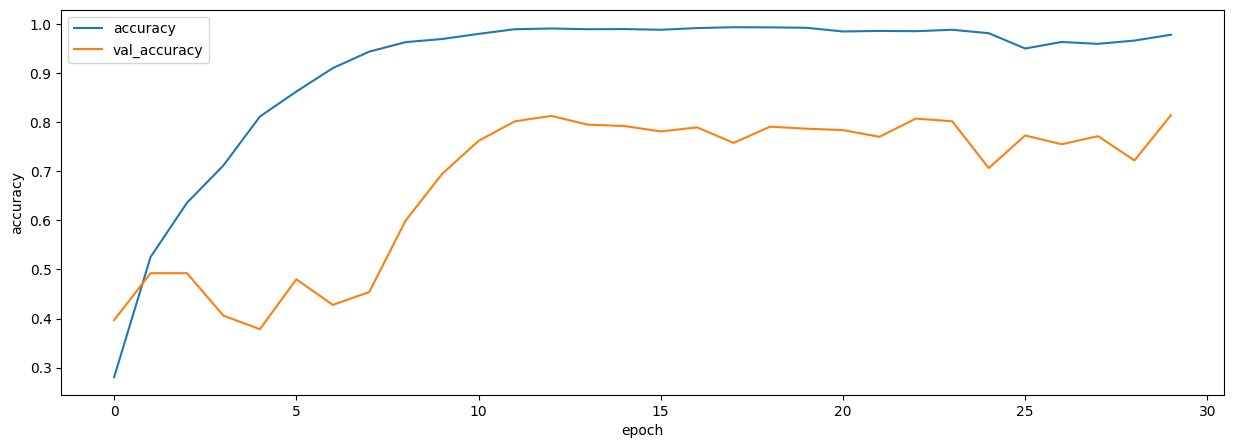

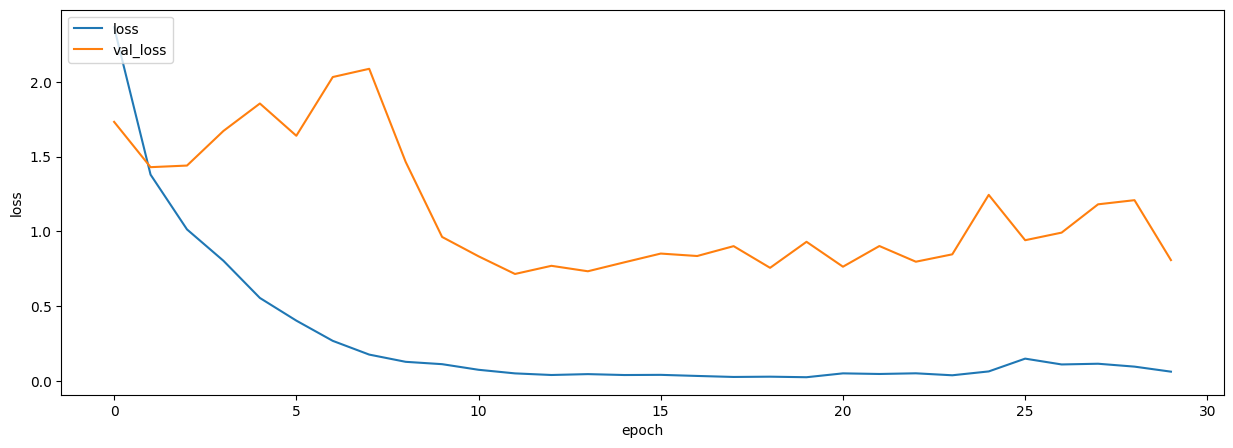

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.8067 - loss: 0.8530 
Accuracy: 0.8157543540000916
Loss: 0.7876900434494019
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step


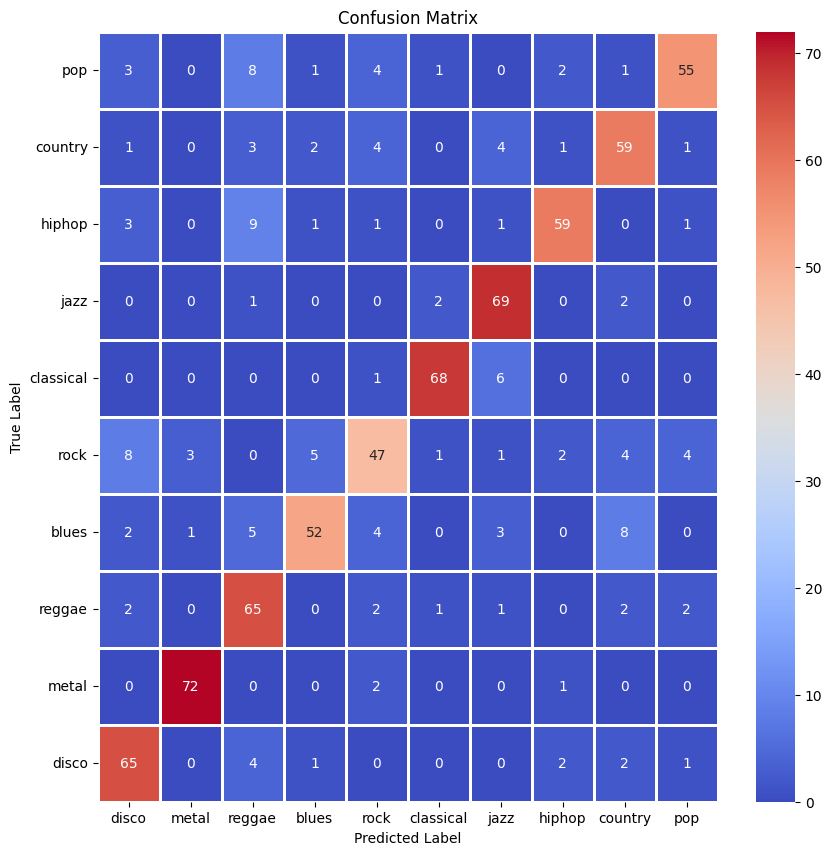

              precision    recall  f1-score   support

           0       0.77      0.87      0.82        75
           1       0.95      0.96      0.95        75
           2       0.68      0.87      0.76        75
           3       0.84      0.69      0.76        75
           4       0.72      0.63      0.67        75
           5       0.93      0.91      0.92        75
           6       0.81      0.93      0.87        74
           7       0.88      0.79      0.83        75
           8       0.76      0.79      0.77        75
           9       0.86      0.73      0.79        75

    accuracy                           0.82       749
   macro avg       0.82      0.82      0.81       749
weighted avg       0.82      0.82      0.81       749



In [48]:
plot_history(history, metric='accuracy')
plot_history(history, metric='loss')

evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

# Mel-Spectrogram

In [35]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/mel_spectrogram', batch_size=batch_size, cache=False)

100%|██████████| 4995/4995 [00:00<00:00, 258517.89it/s]


In [39]:
model = build_combined_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_47       │ (None, 512)       │ 11,451,593 │ input_layer_11[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_49       │ (None, 512)       │ 60,149,248 │ input_layer_11[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 1024)      │          0 │ functional_47[0]… │
│ (Concatenate)       │                   │            │ functional_49[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 1024)      │          0 │ concatenate_5[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 512)       │    524,800 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 10)        │      5,130 │ dense_21[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 72,130,771 (275.16 MB)

 Trainable params: 72,121,805 (275.12 MB)

 Non-trainable params: 8,966 (35.02 KB)

In [40]:
epochs = 30

history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step - accuracy: 0.1982 - loss: 3.3509 - val_accuracy: 0.3818 - val_loss: 1.7280
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 250ms/step - accuracy: 0.4393 - loss: 1.5593 - val_accuracy: 0.4498 - val_loss: 1.5512
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step - accuracy: 0.5786 - loss: 1.1979 - val_accuracy: 0.4195 - val_loss: 1.6977
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step - accuracy: 0.6648 - loss: 0.9621 - val_accuracy: 0.4718 - val_loss: 1.5633
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 248ms/step - accuracy: 0.7241 - loss: 0.7854 - val_accuracy: 0.4897 - val_loss: 1.4556
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 248ms/step - accuracy: 0.7981 - loss: 0.5999 - val_accuracy: 0.4746 - val_loss: 1.5201
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 248ms/step - accuracy: 0.8411 - loss: 0.4770 - val_accuracy: 0.4168 - val_loss: 1.9972
Epoch 8/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step - accuracy: 0.8875 - loss: 0

Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_47       │ (None, 512)       │ 11,451,593 │ input_layer_11[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_49       │ (None, 512)       │ 60,149,248 │ input_layer_11[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 1024)      │          0 │ functional_47[0]… │
│ (Concatenate)       │                   │            │ functional_49[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 1024)      │          0 │ concatenate_5[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 512)       │    524,800 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 10)        │      5,130 │ dense_21[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 216,374,383 (825.40 MB)

 Trainable params: 72,121,805 (275.12 MB)

 Non-trainable params: 8,966 (35.02 KB)

 Optimizer params: 144,243,612 (550.25 MB)

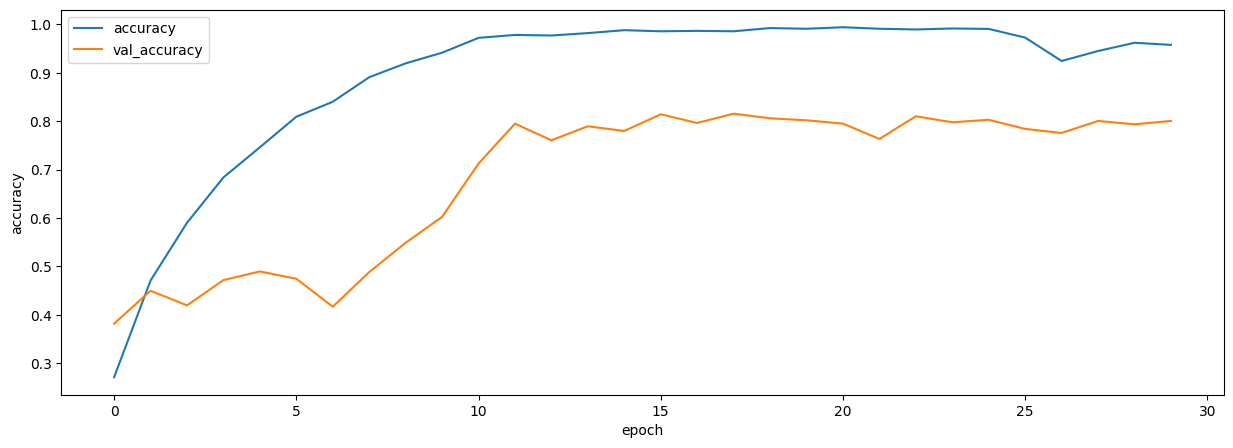

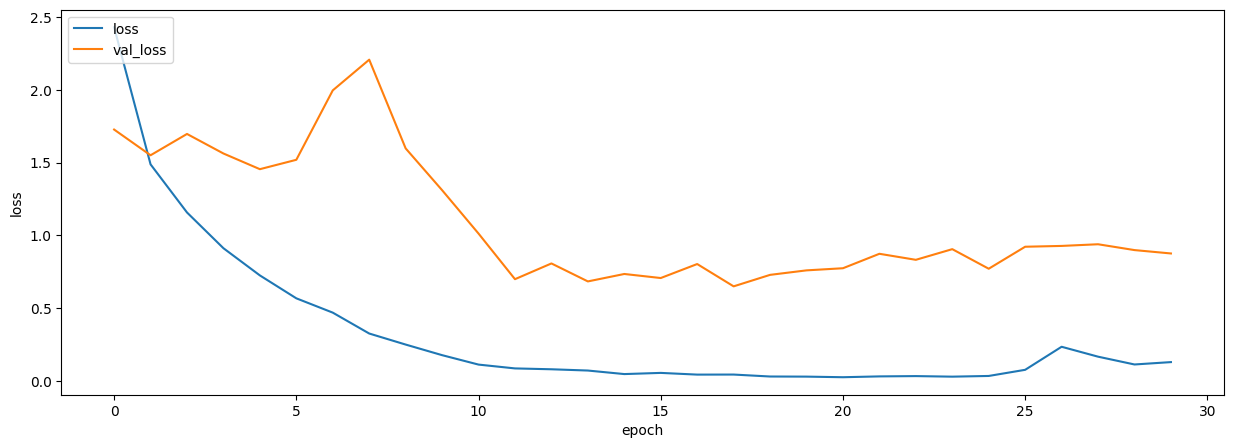

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7780 - loss: 1.0533
Accuracy: 0.7770360708236694
Loss: 0.9964863061904907
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step


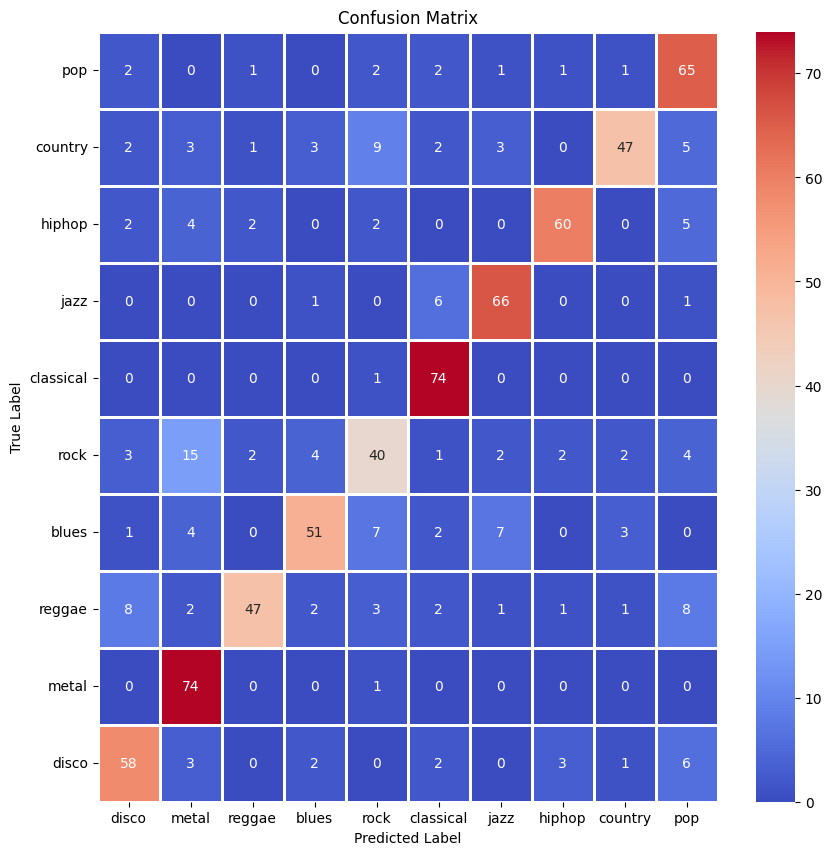

              precision    recall  f1-score   support

           0       0.76      0.77      0.77        75
           1       0.70      0.99      0.82        75
           2       0.89      0.63      0.73        75
           3       0.81      0.68      0.74        75
           4       0.62      0.53      0.57        75
           5       0.81      0.99      0.89        75
           6       0.82      0.89      0.86        74
           7       0.90      0.80      0.85        75
           8       0.85      0.63      0.72        75
           9       0.69      0.87      0.77        75

    accuracy                           0.78       749
   macro avg       0.79      0.78      0.77       749
weighted avg       0.79      0.78      0.77       749



In [41]:
plot_history(history, metric='accuracy')
plot_history(history, metric='loss')

evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))